# Download Dataset

The Dataset for this Project is Given on the drive with the name of ___Data___. ___Data___ folder has 2 subfolders with the name of ___Images___, Which contains Histopathological Images and ___Masks___ Which containg the masks of images.
Downloading link for data set is https://drive.google.com/drive/folders/14DtM2x4UfIQR0au6LDARSb8YaLuagczJ?usp=sharing

# Import Libraries

In [2]:
import os 
import numpy as np 
import seaborn as sns
import cv2 as cv 
import glob
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import math
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint


# Segmentation

## Prepare Data

In [3]:
class Prepare_Data:
    def __init__(self,image_path,mask_path):
        # load all the images and masks from the given path
        self.image_path = image_path
        self.mask_path = mask_path
        self.images = glob.glob(self.image_path)
        self.masks = glob.glob(self.mask_path)
        print(len(self.images),len(self.masks))
        self.images.sort()
        self.masks.sort()
        self.image_list = []
        self.mask_list = []
    
    def load_images(self):
        # load all the images from the given path
        for image in self.images:
            img = cv.imread(image)
            def gama(image,g):
                image=np.divide(image,255)
                gimage=255*(np.power(image,g))
                return np.array(gimage,np.uint8)
            img=gama(img,1.2)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            self.image_list.append(img)
        return np.array(self.image_list)
    
    def load_masks(self):
        # load all the masks from the given path
        for mask in self.masks:
            img = cv.imread(mask)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            self.mask_list.append(img)
        return np.array(self.mask_list)



In [4]:
def one_hot_encoding(masks,colormap):
    new_mask = np.zeros((masks.shape[0], 256, 256, 12), dtype=bool)
    for i in range(masks.shape[0]):
        for j in colormap:
            new_mask[i,:,:,j] = np.all(masks[i] == colormap[j], axis=2)
    return new_mask

In [5]:
colormap={
    0: (108, 0, 155),
    1: (145, 1, 122),
    2: (216, 47, 148),
    3: (254, 246, 242),
    4: (181, 9, 130),
    5: (236, 85, 157),
    6: (73, 0, 106),
    7: (248, 123, 168),
    8: (0, 0, 0),
    9: (127, 255, 255),
    10: (127, 255, 142),
    11: (255, 127, 127)    
}



In [6]:
data=Prepare_Data('/kaggle/input/dataset/data/Images/*.png','/kaggle/input/dataset/data/Masks/*.png')
images=data.load_images()
masks=data.load_masks()
del data
masks=one_hot_encoding(masks,colormap)
images,masks=shuffle(images,masks,random_state=42)

1200 1200


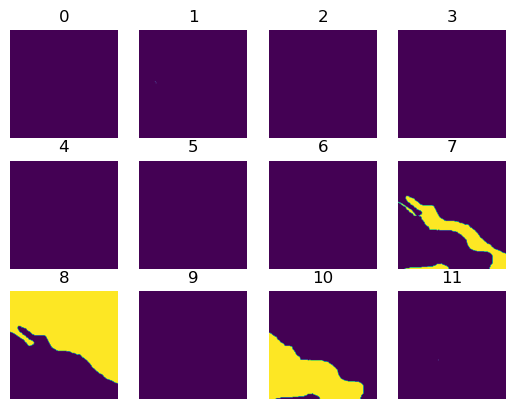

In [7]:
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(masks[1,:,:,i])
    plt.title(i)
    plt.axis('off')

## Create Model

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # First layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),\
                kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),\
                kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def Unet(input_img, n_filters=16, dropout=0.1, batchnorm=True, num_classes=12):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [9]:

import keras.backend as K

def iou_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

def mean_iou(y_true, y_pred):
    iou = iou_coefficient(y_true, y_pred)
    mean_iou = K.mean(iou)
    return mean_iou

input_img = Input((256, 256, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True, num_classes=12)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy", mean_iou])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Train Model

In [11]:

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
history = model.fit(images, masks, batch_size=4, epochs=50, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/50


2023-06-06 03:35:20.584749: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


240/240 [==============================] - 35s 55ms/step - loss: 1.3020 - accuracy: 0.6459 - mean_iou: 0.2662 - val_loss: 4.2468 - val_accuracy: 0.2494 - val_mean_iou: 0.1077
Epoch 2/50
240/240 [==============================] - 12s 48ms/step - loss: 0.9521 - accuracy: 0.7189 - mean_iou: 0.3935 - val_loss: 1.6997 - val_accuracy: 0.3552 - val_mean_iou: 0.1724
Epoch 3/50
240/240 [==============================] - 12s 50ms/step - loss: 0.8157 - accuracy: 0.7421 - mean_iou: 0.4475 - val_loss: 2.5654 - val_accuracy: 0.1462 - val_mean_iou: 0.1043
Epoch 4/50
240/240 [==============================] - 11s 48ms/step - loss: 0.7532 - accuracy: 0.7614 - mean_iou: 0.4822 - val_loss: 2.3704 - val_accuracy: 0.3532 - val_mean_iou: 0.1791
Epoch 5/50
240/240 [==============================] - 11s 47ms/step - loss: 0.7087 - accuracy: 0.7706 - mean_iou: 0.5010 - val_loss: 2.1177 - val_accuracy: 0.3574 - val_mean_iou: 0.1854
Epoch 6/50
240/240 [==============================] - 12s 49ms/step - loss: 0.651

## Plot Learning curve

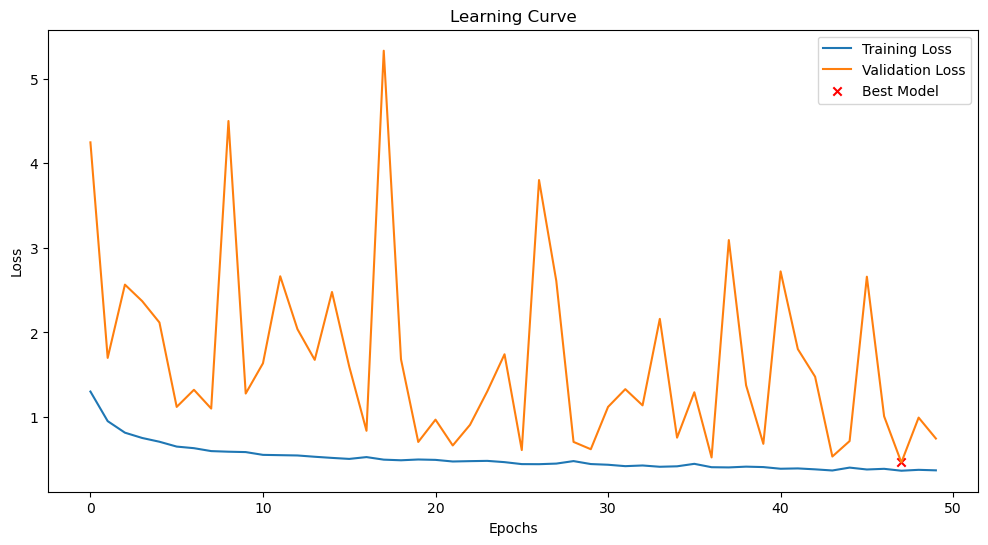

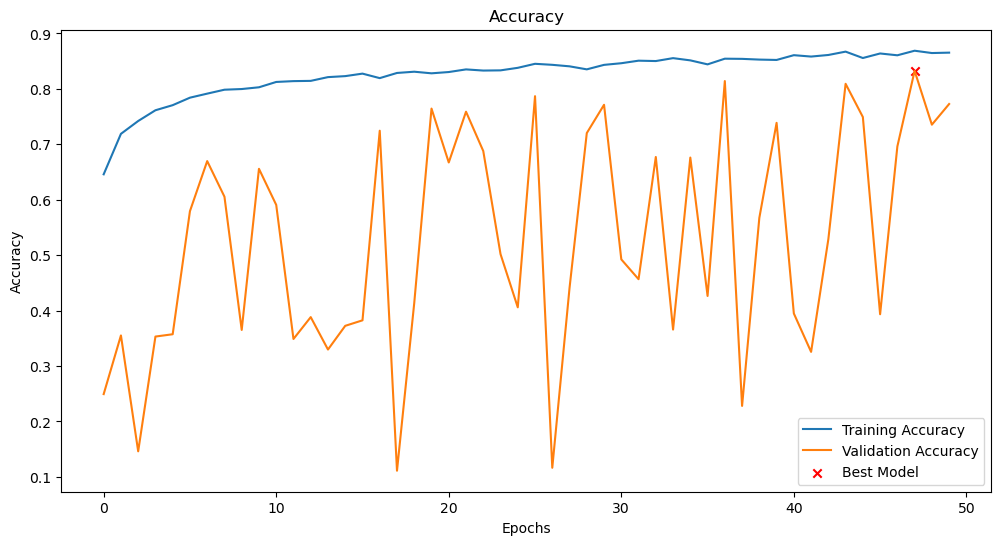

In [14]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Find the epoch with the best validation loss
best_epoch = np.argmin(history.history['val_loss'])

# Add a cross marker at the best epoch
best_loss = history.history['val_loss'][best_epoch]
plt.scatter(best_epoch, best_loss, marker='x', color='r', label='Best Model')

plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add a cross marker at the best epoch
best_accuracy = history.history['val_accuracy'][best_epoch]
plt.scatter(best_epoch, best_accuracy, marker='x', color='r', label='Best Model')

plt.legend()
plt.show()

In [15]:
data=Prepare_Data('/kaggle/input/dataset/data/Train_img/*.png','/kaggle/input/dataset/data/Train_mask/*.png')
Test_images=data.load_images()
Test_masks=data.load_masks()
del data
masks=one_hot_encoding(Test_masks,colormap)
Test_images,Test_masks=shuffle(Test_images,masks,random_state=42)

300 300


10/10 [==============================] - 3s 129ms/step
F1 score: 0.732


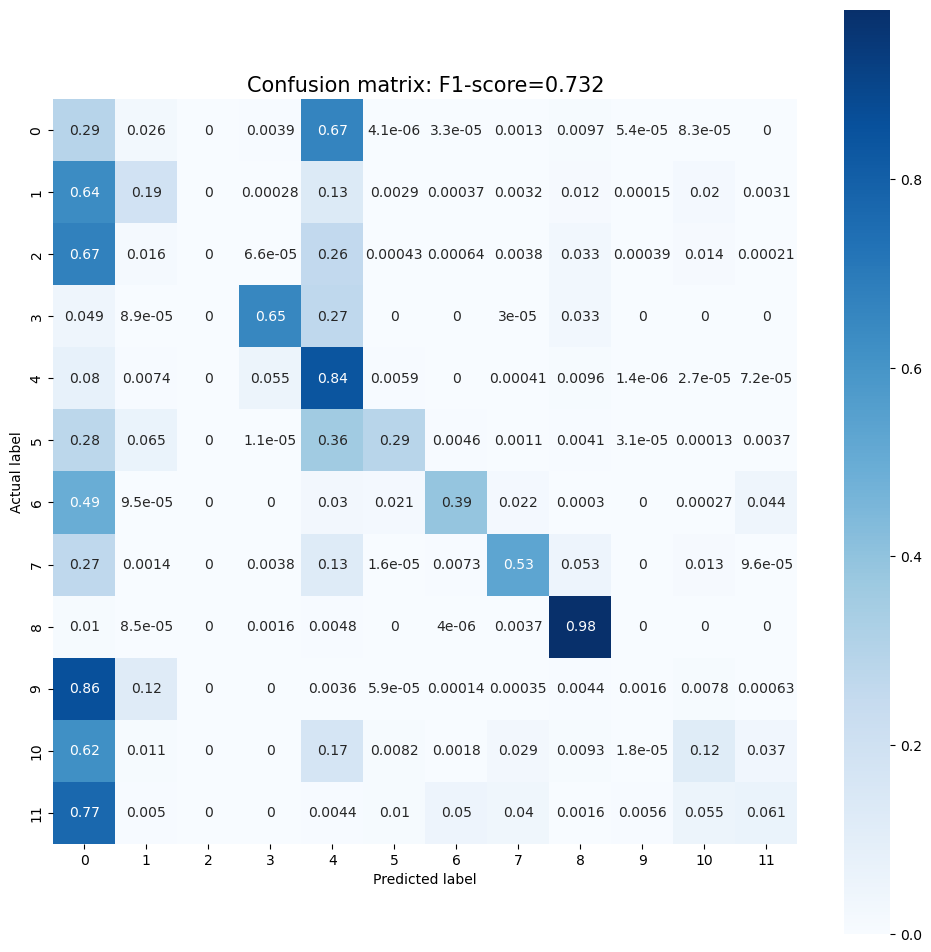

In [16]:
# F1 Score and  Plot Confusion Matrix
from sklearn.metrics import f1_score, confusion_matrix
model.load_weights('best_model.h5')
preds = model.predict(Test_images, verbose=1)
preds_t = (preds > 0.5).astype(np.uint8)

f1 = f1_score(Test_masks.reshape(-1, 12).argmax(axis=1), preds_t.reshape(-1, 12).argmax(axis=1), average='micro')
print('F1 score: {:.3f}'.format(f1))

cm = confusion_matrix(Test_masks.reshape(-1, 12).argmax(axis=1), preds_t.reshape(-1, 12).argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, square=True, cmap='Blues', xticklabels=colormap, yticklabels=colormap)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix: F1-score={:.3f}'.format(f1), size=15)
plt.show()



# Classification

## Prepare Data

In [17]:
data=Prepare_Data('/kaggle/input/dataset/data/Masks/*.png','/kaggle/input/dataset/data/Train_mask/*.png')
Train_masks=data.load_images()
Test_masks=data.load_masks()
Train_masks_data=one_hot_encoding(Train_masks,colormap)
Test_masks_data=one_hot_encoding(Test_masks,colormap)
Train_masks=os.listdir('/kaggle/input/dataset/data/Masks/')
Train_masks.sort
Test_masks=os.listdir('/kaggle/input/dataset/data/Train_mask/')
Test_masks.sort
Train_labels=np.zeros((len(Train_masks),3))
Test_labels=np.zeros((len(Test_masks),3))

for i in range(len(Train_masks)):
    if Train_masks[i][0]=='B':
        Train_labels[i][0]=1
    elif Train_masks[i][0]=='S':
        Train_labels[i][1]=1
    else:
        Train_labels[i][2]=1
        
for i in range(len(Test_masks)):
    if Test_masks[i][0]=='B':
        Test_labels[i][0]=1
    elif Test_masks[i][0]=='S':
        Test_labels[i][1]=1
    else:
        Test_labels[i][2]=1
    


1200 300


## Create Model

In [18]:
class Classification:
    def __init__(self):
        pass
    def build(self,classes):
        inputs=Input(shape=(256,256,12))
        conv1=Conv2D(8,3,activation='relu',padding='same')(inputs)
        conv1=BatchNormalization()(conv1)
        Pooll=MaxPooling2D(pool_size=(2,2))(conv1)
        
        conv2=Conv2D(16,3,activation='relu',padding='same')(Pooll)
        conv2=BatchNormalization()(conv2)
        Pooll=MaxPooling2D(pool_size=(2,2))(conv2)
    
        conv3=Conv2D(32,3,activation='relu',padding='same')(Pooll)
        conv3=BatchNormalization()(conv3)
        Pooll=MaxPooling2D(pool_size=(2,2))(conv3)
        
        conv4=Conv2D(64,3,activation='relu',padding='same')(Pooll)
        conv4=BatchNormalization()(conv4)
        Pooll=MaxPooling2D(pool_size=(2,2))(conv4)
        
        conv5=Conv2D(128,3,activation='relu',padding='same')(Pooll)
        conv5=BatchNormalization()(conv5)
        drop5=Dropout(0.5)(conv5)
        
        x=GlobalAveragePooling2D()(drop5)
        
        x=Dense(128,activation='relu',name='Dense')(x)
        x=Dense(64,activation='relu',name='Dense1')(x)
        x=Dense(32,activation='relu',name='Dense2')(x)
        x=Dense(16,activation='relu',name='Dense3')(x)
        x=Dense(8,activation='relu',name='Dense4')(x)
        x=Dense(classes,activation='softmax',name='Dense5')(x)
        
        mymodel=Model(inputs=inputs,outputs=x)
        optimizer=Adam(lr=0.00001)
        mymodel.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
        mymodel.summary()
        return mymodel
    


In [19]:
Classification_model = Classification()
Classification_model=Classification_model.build(3)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 12)]    0         
                                                                 
 conv2d_19 (Conv2D)          (None, 256, 256, 8)       872       
                                                                 
 batch_normalization_18 (Bat  (None, 256, 256, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 batch_normalization_19 (Bat  (None, 128, 128, 16)     64  

## Train Model

In [20]:
history=Classification_model.fit(Train_masks_data,Train_labels,epochs=100,batch_size=32,validation_split=0.2)

Epoch 1/100


2023-06-06 03:51:16.893039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 8s 77ms/step - loss: 1.1069 - accuracy: 0.3281 - val_loss: 1.0988 - val_accuracy: 0.3458
Epoch 2/100
30/30 [==============================] - 2s 51ms/step - loss: 1.1000 - accuracy: 0.3156 - val_loss: 1.0987 - val_accuracy: 0.3458
Epoch 3/100
30/30 [==============================] - 2s 56ms/step - loss: 1.0993 - accuracy: 0.3167 - val_loss: 1.0986 - val_accuracy: 0.3458
Epoch 4/100
30/30 [==============================] - 2s 51ms/step - loss: 1.0964 - accuracy: 0.3344 - val_loss: 1.0986 - val_accuracy: 0.3458
Epoch 5/100
30/30 [==============================] - 2s 51ms/step - loss: 1.0977 - accuracy: 0.3469 - val_loss: 1.0995 - val_accuracy: 0.3458
Epoch 6/100
30/30 [==============================] - 2s 50ms/step - loss: 1.0994 - accuracy: 0.3417 - val_loss: 1.1001 - val_accuracy: 0.3458
Epoch 7/100
30/30 [==============================] - 2s 51ms/step - loss: 1.0974 - accuracy: 0.3573 - val_loss: 1.0973 - val_accuracy: 0.3417
Epoch 8/100
30/30 

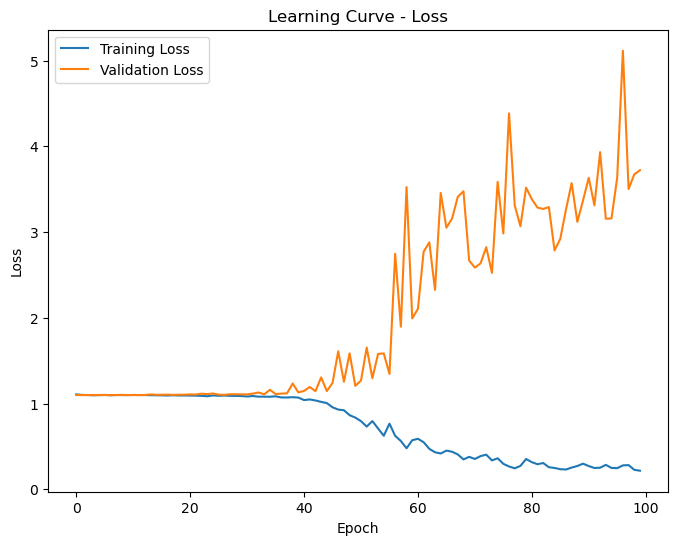

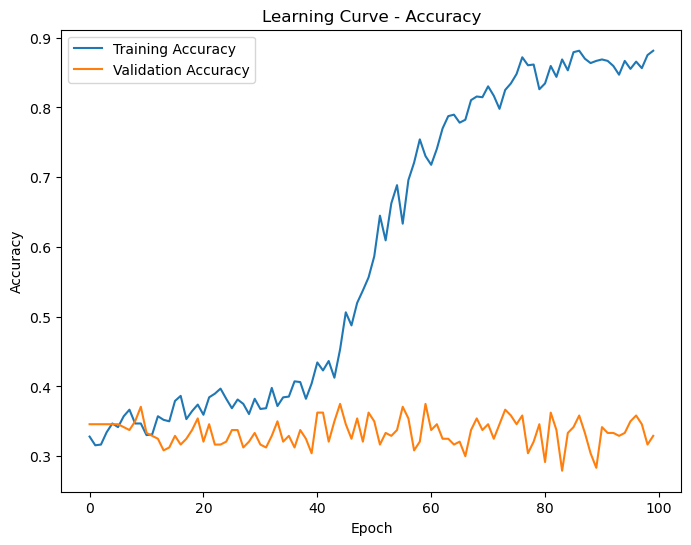

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

10/10 [==============================] - 0s 31ms/step


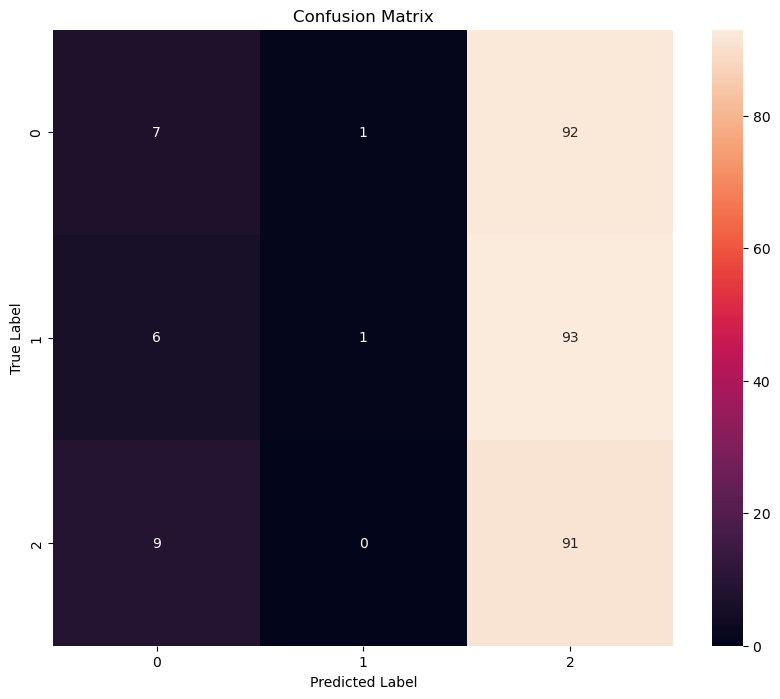

F1 Score for each class
BCC:  0.11475409836065574
SCC  0.0196078431372549
IEC:  0.48404255319148937


In [22]:
# F1 Score and Confusion Matrix
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

Test_pred = Classification_model.predict(Test_masks_data)
Test_pred_classes = np.argmax(Test_pred, axis=1)
Test_true = np.argmax(Test_labels, axis=1)
confusion_mtx = confusion_matrix(Test_true, Test_pred_classes) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




# print f1 scores
print("F1 Score for each class")
print("BCC: ", f1_score(Test_true, Test_pred_classes, average=None)[0])
print("SCC ", f1_score(Test_true, Test_pred_classes, average=None)[1])
print("IEC: ", f1_score(Test_true, Test_pred_classes, average=None)[2])

